This notebook provides examples to go along with the [textbook](http://manipulation.csail.mit.edu/pick.html).  I recommend having both windows open, side-by-side!

In [ ]:
import mpld3
import numpy as np
from matplotlib import pyplot as plt
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    AngleAxis,
    DiagramBuilder,
    Integrator,
    JacobianWrtVariable,
    LeafSystem,
    MeshcatVisualizer,
    MultibodyPlant,
    MultibodyPositionToGeometryPose,
    Parser,
    PiecewisePolynomial,
    PiecewisePose,
    Quaternion,
    Rgba,
    RigidTransform,
    RotationMatrix,
    SceneGraph,
    Simulator,
    StartMeshcat,
    TrajectorySource,
)

from manipulation import running_as_notebook
from manipulation.utils import RenderDiagram
from manipulation.station import MakeHardwareStation, load_scenario


if running_as_notebook:
    mpld3.enable_notebook()

In [ ]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://517eb3c1-eddb-47dd-8d8b-4200aa811a30.deepnoteproject.com/7004/


# A pick and place "sketch" with keyframes

Let's first define the canonical frames of our problem.  We've got a handful of them, and will pass them in and out of several functions, so I'll use a dictionary to store them.

Note: I've added one more frame into the mix here, to get some clearance when moving between the bins.  Leaving it out gave me a nice [robot outtake](http://manipulation.csail.mit.edu/data/pick_fail.html).

In [ ]:
def MakeGripperFrames(X_WG, X_WO):
    """
    Takes a partial specification with X_G["initial"] and X_O["initial"] and
    X_0["goal"], and returns a X_G and times with all of the pick and place
    frames populated.
    """
    # Define (again) the gripper pose relative to the object when in grasp.
    p_GgraspO = [0, 0.12, 0]
    R_GgraspO = RotationMatrix.MakeXRotation(
        np.pi / 2.0
    ) @ RotationMatrix.MakeZRotation(np.pi / 2.0)
    X_GgraspO = RigidTransform(R_GgraspO, p_GgraspO)
    X_OGgrasp = X_GgraspO.inverse()
    # pregrasp is negative y in the gripper frame (see the figure!).
    X_GgraspGpregrasp = RigidTransform([0, -0.08, 0])

    X_WG["pick"] = X_WO["initial"] @ X_OGgrasp
    X_WG["prepick"] = X_WG["pick"] @ X_GgraspGpregrasp
    X_WG["place"] = X_WO["goal"] @ X_OGgrasp
    X_WG["preplace"] = X_WG["place"] @ X_GgraspGpregrasp

    # I'll interpolate a halfway orientation by converting to axis angle and halving the angle.
    X_GprepickGpreplace = X_WG["prepick"].inverse() @ X_WG["preplace"]
    angle_axis = X_GprepickGpreplace.rotation().ToAngleAxis()
    X_GprepickGclearance = RigidTransform(
        AngleAxis(angle=angle_axis.angle() / 2.0, axis=angle_axis.axis()),
        X_GprepickGpreplace.translation() / 2.0 + np.array([0, -0.3, 0]),
    )
    X_WG["clearance"] = X_WG["prepick"] @ X_GprepickGclearance

    # Now let's set the timing
    times = {"initial": 0}
    X_GinitialGprepick = X_G["initial"].inverse() @ X_WG["prepick"]
    times["prepick"] = times["initial"] + 10.0 * np.linalg.norm(
        X_GinitialGprepick.translation()
    )
    # Allow some time for the gripper to close.
    times["pick_start"] = times["prepick"] + 2.0
    times["pick_end"] = times["pick_start"] + 2.0
    X_WG["pick_start"] = X_WG["pick"]
    X_WG["pick_end"] = X_WG["pick"]
    times["postpick"] = times["pick_end"] + 2.0
    X_WG["postpick"] = X_WG["prepick"]
    time_to_from_clearance = 10.0 * np.linalg.norm(
        X_GprepickGclearance.translation()
    )
    times["clearance"] = times["postpick"] + time_to_from_clearance
    times["preplace"] = times["clearance"] + time_to_from_clearance
    times["place_start"] = times["preplace"] + 2.0
    times["place_end"] = times["place_start"] + 2.0
    X_WG["place_start"] = X_WG["place"]
    X_WG["place_end"] = X_WG["place"]
    times["postplace"] = times["place_end"] + 2.0
    X_WG["postplace"] = X_WG["preplace"]

    return X_WG, times


X_G = {
    "initial": RigidTransform(
        RotationMatrix.MakeXRotation(-np.pi / 2.0), [0, -0.25, 0.25]
    )
}
X_O = {
    "initial": RigidTransform(
        RotationMatrix.MakeZRotation(np.pi / 2.0), [-0.2, -0.75, 0.025]
    ),
    "goal": RigidTransform(
        RotationMatrix.MakeZRotation(np.pi), [0.75, 0, 0.025]
    ),
}
X_G, times = MakeGripperFrames(X_G, X_O)
print(
    f"Sanity check: The entire maneuver will take {times['postplace']} seconds to execute."
)

Sanity check: The entire maneuver will take 30.900220749318255 seconds to execute.


Here's a simple visualization of those frames.  Use the controls menu in meshcat to view the different objects on the different "paths" to understand which objects belong to which frames.  Everything look reasonable?

Try changing the initial and final pose of the gripper / object.

In [ ]:
def visualize_gripper_frames(X_G, X_O):
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    parser = Parser(plant, scene_graph)
    parser.SetAutoRenaming(True)
    for key, pose in X_G.items():
        g = parser.AddModelsFromUrl(
            "package://drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf"
        )[0]
        plant.WeldFrames(
            plant.world_frame(), plant.GetFrameByName("body", g), pose
        )
    for key, pose in X_O.items():
        o = parser.AddModelsFromUrl(
            "package://drake/examples/manipulation_station/models/061_foam_brick.sdf"
        )[0]
        plant.WeldFrames(
            plant.world_frame(), plant.GetFrameByName("base_link", o), pose
        )

    plant.Finalize()

    meshcat.Delete()
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.ForcedPublish(context)


visualize_gripper_frames(X_G, X_O)

# Pick and place trajectories

We've defined the keyframes, but now we will fill in timing details (what should be happening at each instant).

Interpolating between the positions is quite simple; we can encode these details as a `PiecewisePolynomial` trajectory in $\Re^3$ over time.  Interpolating over orientations requires more care.  We'll use `PiecewiseQuaternionSlerp` to do the job.

See the documentation of [PiecewisePose](https://drake.mit.edu/doxygen_cxx/classdrake_1_1trajectories_1_1_piecewise_pose.html#ae2f8a49b642aecb5c19ef3625be5e61d) for more details.

In [ ]:
def MakeGripperPoseTrajectory(X_G, times):
    """
    Constructs a gripper position trajectory from the plan "sketch".
    """

    sample_times = []
    poses = []
    for name in [
        "initial",
        "prepick",
        "pick_start",
        "pick_end",
        "postpick",
        "clearance",
        "preplace",
        "place_start",
        "place_end",
        "postplace",
    ]:
        sample_times.append(times[name])
        poses.append(X_G[name])

    return PiecewisePose.MakeLinear(sample_times, poses)


traj_X_G = MakeGripperPoseTrajectory(X_G, times)

Now let's plot our trajectories.

In [ ]:
traj_p_G = traj_X_G.get_position_trajectory()

p_G = traj_p_G.vector_values(traj_p_G.get_segment_times())
plt.plot(traj_p_G.get_segment_times(), p_G.T)
plt.legend(["x", "y", "z"])
plt.title("p_G")
mpld3.display()

We can also plot the trajectory in 3D directly in Meshcat.

In [ ]:
meshcat.ResetRenderMode()
meshcat.SetLine("p_G", p_G, 2.0, rgba=Rgba(1, 0.65, 0))

We can plot the orientation trajectory, too.  Here are the components of the quaternion over time.

In [ ]:
traj_R_G = traj_X_G.get_orientation_trajectory()
R_G = traj_R_G.vector_values(traj_R_G.get_segment_times())
plt.plot(traj_R_G.get_segment_times(), R_G.T)
plt.legend(["qx", "qy", "qz", "qw"])
plt.title("R_G")
mpld3.display()

Better, I think, to just plot the entire result.  Before we do, let's quickly define the finger trajectory.

In [ ]:
def MakeGripperCommandTrajectory(times):
    opened = np.array([0.107])
    closed = np.array([0.0])

    traj_wsg_command = PiecewisePolynomial.FirstOrderHold(
        [times["initial"], times["pick_start"]],
        np.hstack([[opened], [opened]]),
    )
    traj_wsg_command.AppendFirstOrderSegment(times["pick_end"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["place_start"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["place_end"], opened)
    traj_wsg_command.AppendFirstOrderSegment(times["postplace"], opened)
    return traj_wsg_command


traj_wsg_command = MakeGripperCommandTrajectory(times)

In [ ]:
wsg_command = traj_wsg_command.vector_values(
    traj_wsg_command.get_segment_times()
)
plt.plot(traj_wsg_command.get_segment_times(), wsg_command.T)
plt.title("wsg_command")
mpld3.display()

Now let's really visualize the trajectory.  The best way is to animate it in 3D!  Please forgive the messiness of this particular bit of code; I'm trying to provide some intermediate steps that aren't typically used by the main drake developers.

TODO(russt): make this less "bespoke".

In [ ]:
class GripperTrajectoriesToPosition(LeafSystem):
    def __init__(self, plant, traj_p_G, traj_R_G, traj_wsg_command):
        LeafSystem.__init__(self)
        self.plant = plant
        self.gripper_body = plant.GetBodyByName("body")
        self.left_finger_joint = plant.GetJointByName(
            "left_finger_sliding_joint"
        )
        self.right_finger_joint = plant.GetJointByName(
            "right_finger_sliding_joint"
        )
        self.traj_p_G = traj_p_G
        self.traj_R_G = traj_R_G
        self.traj_wsg_command = traj_wsg_command
        self.plant_context = plant.CreateDefaultContext()

        self.DeclareVectorOutputPort(
            "position", plant.num_positions(), self.CalcPositionOutput
        )

    def CalcPositionOutput(self, context, output):
        t = context.get_time()
        X_G = RigidTransform(
            Quaternion(self.traj_R_G.value(t)), self.traj_p_G.value(t)
        )
        self.plant.SetFreeBodyPose(self.plant_context, self.gripper_body, X_G)
        wsg = self.traj_wsg_command.value(t)[0, 0]
        self.left_finger_joint.set_translation(self.plant_context, -wsg / 2.0)
        self.right_finger_joint.set_translation(self.plant_context, wsg / 2.0)
        output.SetFromVector(self.plant.GetPositions(self.plant_context))


def visualize_pick_and_place_trajectory(
    traj_p_G, traj_R_G, traj_wsg_command, X_O
):
    builder = DiagramBuilder()

    # Note: Don't use AddMultibodyPlantSceneGraph because we are only using
    # MultibodyPlant for parsing, then wiring directly to SceneGraph.
    scene_graph = builder.AddSystem(SceneGraph())
    plant = MultibodyPlant(time_step=0.0)
    plant.RegisterAsSourceForSceneGraph(scene_graph)
    parser = Parser(plant, scene_graph)
    parser.SetAutoRenaming(True)
    gripper = parser.AddModelsFromUrl(
        "package://drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf"
    )[0]
    brick = "package://drake/examples/manipulation_station/models/061_foam_brick.sdf"
    for key, pose in X_O.items():
        o = parser.AddModelsFromUrl(brick)[0]
        plant.WeldFrames(
            plant.world_frame(), plant.GetFrameByName("base_link", o), pose
        )
    plant.Finalize()

    to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(plant))
    builder.Connect(
        to_pose.get_output_port(),
        scene_graph.get_source_pose_port(plant.get_source_id()),
    )

    traj_to_position = builder.AddSystem(
        GripperTrajectoriesToPosition(
            plant, traj_p_G, traj_R_G, traj_wsg_command
        )
    )
    builder.Connect(
        traj_to_position.get_output_port(), to_pose.get_input_port()
    )

    meshcat.Delete()
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()

    simulator = Simulator(diagram)
    meshcat.StartRecording(set_visualizations_while_recording=False)
    simulator.AdvanceTo(traj_p_G.end_time() if running_as_notebook else 0.1)
    meshcat.PublishRecording()


visualize_pick_and_place_trajectory(traj_p_G, traj_R_G, traj_wsg_command, X_O)

# Putting it all together

In the visualization above, we animated the plan, but did not actually command the robot!  Let's put our grasping trajectories back together with our Jacobian-based controller.

The first thing you might have noticed is that the Jacobian controller takes spatial velocities as input.  But so far we have trajectories for positions and orientations.  Let's differentiate them to get the velocities.

In [ ]:
traj_v_G = traj_p_G.MakeDerivative()

v_G = traj_v_G.vector_values(traj_v_G.get_segment_times())
plt.plot(traj_v_G.get_segment_times(), v_G.T)
plt.legend(["vx", "vy", "vz"])
plt.title("v_G")
mpld3.display()

Now we need a slightly modified version of our Jacobian controller, which can take the spatial velocity commands from an input port.

In [ ]:
class PseudoInverseController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa")
        self._G = plant.GetBodyByName("body").body_frame()
        self._W = plant.world_frame()

        self.V_G_port = self.DeclareVectorInputPort("V_WG", 6)
        self.q_port = self.DeclareVectorInputPort("iiwa.position", 7)
        self.DeclareVectorOutputPort("iiwa.velocity", 7, self.CalcOutput)
        self.iiwa_start = plant.GetJointByName("iiwa_joint_1").velocity_start()
        self.iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()

    def CalcOutput(self, context, output):
        V_G = self.V_G_port.Eval(context)
        q = self.q_port.Eval(context)
        self._plant.SetPositions(self._plant_context, self._iiwa, q)
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context,
            JacobianWrtVariable.kV,
            self._G,
            [0, 0, 0],
            self._W,
            self._W,
        )
        J_G = J_G[:, self.iiwa_start : self.iiwa_end + 1]  # Only iiwa terms.
        v = np.linalg.pinv(J_G).dot(V_G)
        output.SetFromVector(v)

Oh, boy.  Big moment.  I'm excited... are you?  Let's do this thing!

In [ ]:
X_O = {
    "initial": RigidTransform(
        RotationMatrix.MakeZRotation(np.pi / 2.0), [0, -0.6, 0.0]
    ),
    "goal": RigidTransform(RotationMatrix.MakeZRotation(np.pi), [0.5, 0, 0.0]),
}

meshcat.Delete()
builder = DiagramBuilder()

scenario_data = """
directives:
- add_directives:
    file: package://manipulation/clutter.dmd.yaml
- add_model:
    name: foam_brick
    file: package://manipulation/hydro/061_foam_brick.sdf
model_drivers:
    iiwa: !IiwaDriver
      hand_model_name: wsg
    wsg: !SchunkWsgDriver {}
"""

scenario = load_scenario(data=scenario_data)
station = builder.AddSystem(MakeHardwareStation(scenario, meshcat=meshcat))
plant = station.GetSubsystemByName("plant")
plant.SetDefaultFreeBodyPose(plant.GetBodyByName("base_link"), X_O["initial"])

# Find the initial pose of the gripper and object (as set in the default Context)
temp_context = station.CreateDefaultContext()
temp_plant_context = plant.GetMyContextFromRoot(temp_context)
X_G = {
    "initial": plant.EvalBodyPoseInWorld(
        temp_plant_context, plant.GetBodyByName("body")
    )
}
X_O["initial"] = plant.EvalBodyPoseInWorld(
    temp_plant_context, plant.GetBodyByName("base_link")
)
X_G, times = MakeGripperFrames(X_G, X_O)
print(
    f"Sanity check: The entire maneuver will take {times['postplace']} seconds to execute."
)

# Make the trajectories
traj = MakeGripperPoseTrajectory(X_G, times)
traj_V_G = traj.MakeDerivative()

V_G_source = builder.AddSystem(TrajectorySource(traj_V_G))
V_G_source.set_name("v_WG")
controller = builder.AddSystem(PseudoInverseController(plant))
controller.set_name("PseudoInverseController")
builder.Connect(V_G_source.get_output_port(), controller.GetInputPort("V_WG"))

integrator = builder.AddSystem(Integrator(7))
integrator.set_name("integrator")
builder.Connect(controller.get_output_port(), integrator.get_input_port())
builder.Connect(
    integrator.get_output_port(), station.GetInputPort("iiwa.position")
)
builder.Connect(
    station.GetOutputPort("iiwa.position_measured"),
    controller.GetInputPort("iiwa.position"),
)

traj_wsg_command = MakeGripperCommandTrajectory(times)
wsg_source = builder.AddSystem(TrajectorySource(traj_wsg_command))
wsg_source.set_name("wsg.command")
builder.Connect(
    wsg_source.get_output_port(), station.GetInputPort("wsg.position")
)

diagram = builder.Build()
diagram.set_name("pick_and_place")

simulator = Simulator(diagram)
context = simulator.get_mutable_context()
station_context = station.GetMyContextFromRoot(context)
integrator.set_integral_value(
    integrator.GetMyContextFromRoot(context),
    plant.GetPositions(
        plant.GetMyContextFromRoot(context),
        plant.GetModelInstanceByName("iiwa"),
    ),
)

diagram.ForcedPublish(context)
meshcat.StartRecording(set_visualizations_while_recording=False)
simulator.AdvanceTo(traj_p_G.end_time() if running_as_notebook else 0.1)
meshcat.PublishRecording()

Sanity check: The entire maneuver will take 26.826891105934223 seconds to execute.


That's quite some diagram we've assembled.  Do you understand all of the parts?

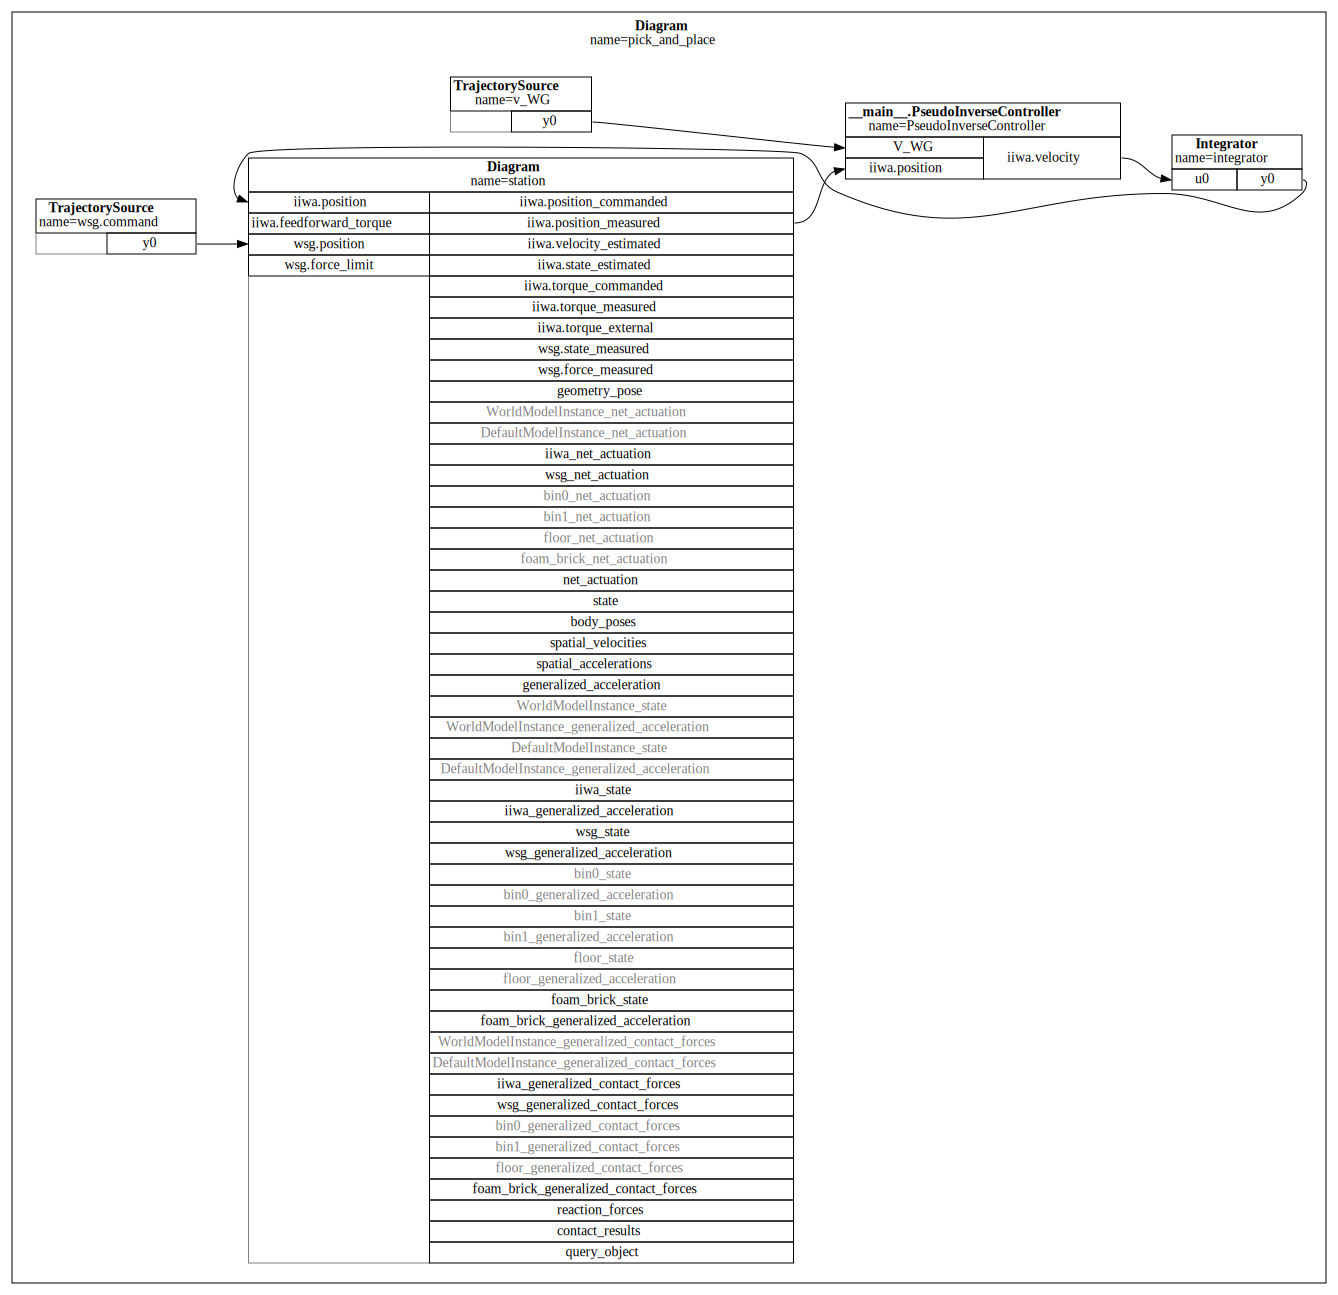

In [ ]:
RenderDiagram(diagram, max_depth=1)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=517eb3c1-eddb-47dd-8d8b-4200aa811a30' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>